In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import warnings
warnings.filterwarnings("ignore")

# === Step 1: Load Data ===
df = pd.read_csv("goup_project_sample_v3.csv", parse_dates=["date"])
factors = pd.read_csv("factor_char_list.csv")["variable"].tolist()

df["date"] = df["date"].dt.to_period("M").dt.to_timestamp()

In [ ]:
df.describe()

,date,ret_eom,permno,SHRCD,EXCHCD,mspread,year,month,RF,stock_exret,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
count,911537,9.115370e+05,911537.000000,911537.000000,911537.000000,910863.000000,911537.000000,911537.000000,911537.000000,911537.000000,...,907780.000000,910819.000000,772779.000000,771975.000000,903302.000000,911537.000000,722698.000000,902553.000000,722705.000000,905658.000000
mean,2010-12-15 06:41:27.986774016,2.010571e+07,64785.349724,10.999946,2.490679,0.016225,2010.503317,6.429465,0.001629,0.008910,...,0.918927,0.016178,0.303050,0.976087,1.179553,227.095586,-0.114827,-0.137777,-0.036361,-0.049467
min,2000-01-01 00:00:00,2.000013e+07,10001.000000,10.000000,1.000000,0.000000,2000.000000,1.000000,0.000000,-1.003213,...,-26.955059,0.000000,-0.278785,-4.219358,-0.284377,13.000000,-1.731447,-1.731648,-1.731447,-1.731649
25%,2004-06-01 00:00:00,2.004063e+07,35263.000000,11.000000,2.000000,0.007488,2004.000000,3.000000,0.000100,-0.079914,...,0.410995,0.007528,0.161016,0.502635,0.790975,104.000000,-1.007428,-0.983108,-0.946182,-0.964154
50%,2010-01-01 00:00:00,2.010013e+07,80274.000000,11.000000,3.000000,0.011885,2010.000000,6.000000,0.001100,-0.001500,...,0.886028,0.011930,0.282823,0.892614,1.082285,178.000000,-0.169161,-0.194514,-0.053143,-0.100822
75%,2017-03-01 00:00:00,2.017033e+07,87139.000000,11.000000,3.000000,0.019552,2017.000000,9.000000,0.003100,0.074834,...,1.363617,0.019566,0.435367,1.325351,1.456258,300.000000,0.747751,0.674501,0.855906,0.871929
max,2024-08-01 00:00:00,2.024083e+07,93435.000000,11.000000,3.000000,0.924354,2024.000000,12.000000,0.005600,26.579428,...,26.342897,0.844444,0.847924,10.442941,7.249008,1183.000000,1.731447,1.731651,1.731447,1.731652
std,NaN,7.320452e+04,29751.780764,0.007332,0.818394,0.016538,7.321044,3.441858,0.001667,0.219683,...,0.820617,0.016068,0.173565,0.637443,0.562352,168.286530,1.007136,0.976929,1.026784,1.028605


In [ ]:
# Count non-null values
meanest_count = df['eps_meanest'].notnull().sum()
medest_count = df['eps_medest'].notnull().sum()

# Count how many have at least one of the two
either_count = df[['eps_meanest', 'eps_medest']].notnull().any(axis=1).sum()

# Print results
print(f"Rows with eps_meanest: {meanest_count}")
print(f"Rows with eps_medest: {medest_count}")
print(f"Rows with either eps_meanest or eps_medest: {either_count}")

Rows with eps_meanest: 616758
Rows with eps_medest: 616755
Rows with either eps_meanest or eps_medest: 616760


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import warnings
warnings.filterwarnings("ignore")

# === Step 1: Load Data ===
df = pd.read_csv("goup_project_sample_v3.csv", parse_dates=["date"])
factors = pd.read_csv("factor_char_list.csv")["variable"].tolist()
df["date"] = df["date"].dt.to_period("M").dt.to_timestamp()

# === Step 2: Compute EPS Surprise ===
df = df[df["eps_stdevest"].notna() & (df["eps_stdevest"] > 0)]
df["eps_surprise"] = (df["eps_actual"] - df["eps_meanest"]) / df["eps_stdevest"]


In [ ]:
# Summary statistics
print(df["eps_surprise"].describe())


count    446547.000000
mean         -0.078942
std          11.113905
min       -1450.200000
25%          -1.095238
50%           0.333333
75%           2.000000
max        1132.032558
Name: eps_surprise, dtype: float64


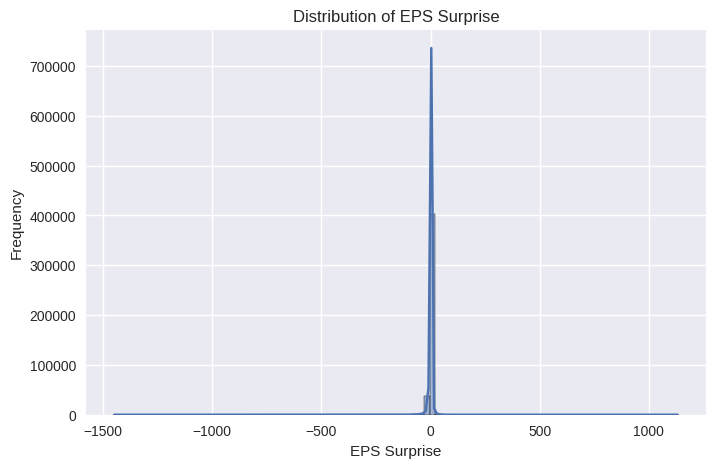

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["eps_surprise"], bins=100, kde=True)
plt.title("Distribution of EPS Surprise")
plt.xlabel("EPS Surprise")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
df["eps_surprise"] = df["eps_surprise"].clip(-3, 3)

# === Step 3: Drop rows with missing outcome or features ===
df = df.dropna(subset=["eps_surprise"] + factors)

# === Step 4: Expanding Window Training with Bayesian Optimization ===
results = []
starting = pd.to_datetime("2000-01-01")
counter = 0

while (starting + pd.DateOffset(years=11 + counter)) <= pd.to_datetime("2024-01-01"):
    cutoff = [
        starting,
        starting + pd.DateOffset(years=8 + counter),
        starting + pd.DateOffset(years=10 + counter),
        starting + pd.DateOffset(years=11 + counter)
    ]

    train = df[(df["date"] >= cutoff[0]) & (df["date"] < cutoff[1])]
    val   = df[(df["date"] >= cutoff[1]) & (df["date"] < cutoff[2])]
    test  = df[(df["date"] >= cutoff[2]) & (df["date"] < cutoff[3])]

    if train.empty or val.empty or test.empty:
        counter += 1
        continue

    # === Preprocessing ===
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[factors])
    y_train = train["eps_surprise"].values
    X_val = scaler.transform(val[factors])
    y_val = val["eps_surprise"].values
    X_test = scaler.transform(test[factors])
    y_test = test["eps_surprise"].values

    # Combine for tuning
    X_comb = np.vstack([X_train, X_val])
    y_comb = np.concatenate([y_train, y_val])
    split_idx = [-1] * len(X_train) + [0] * len(X_val)
    ps = PredefinedSplit(test_fold=split_idx)

    # === Bayesian Optimization ===
    bayes_cv = BayesSearchCV(
        XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
        search_spaces={
            'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
            'max_depth': Integer(3, 7),
            'subsample': Real(0.5, 1.0),
            'colsample_bytree': Real(0.5, 1.0),
            'n_estimators': Integer(50, 300),
        },
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=ps,
        refit=True,
        random_state=42,
        verbose=0
    )
    bayes_cv.fit(X_comb, y_comb)
    model = bayes_cv.best_estimator_

    # === Predict and store
    test_pred = model.predict(X_test)
    temp_df = test[["permno", "date"]].copy()
    temp_df["pred"] = test_pred
    results.append(temp_df)

    print(f"✅ Window {counter + 1} — Best params: {bayes_cv.best_params_}")
    counter += 1

# === Step 5: Save Final Output ===
df_eval = pd.concat(results).dropna()
df_eval.to_csv("epssurprise_regression_bayesopt.csv", index=False)
print(f"\n✅ EPS surprise predictions saved to 'epssurprise_regression_bayesopt.csv'")

✅ Window 1 — Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.03556530002116115), ('max_depth', 7), ('n_estimators', 50), ('subsample', 0.5)])
✅ Window 2 — Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.012015864843661515), ('max_depth', 7), ('n_estimators', 178), ('subsample', 0.6002424847446675)])
✅ Window 3 — Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01577484322995444), ('max_depth', 7), ('n_estimators', 299), ('subsample', 0.5)])
✅ Window 4 — Best params: OrderedDict([('colsample_bytree', 0.6514637703932634), ('learning_rate', 0.03344389420198344), ('max_depth', 6), ('n_estimators', 166), ('subsample', 0.9284180138816089)])
✅ Window 5 — Best params: OrderedDict([('colsample_bytree', 0.6348169382345619), ('learning_rate', 0.012895772092688858), ('max_depth', 7), ('n_estimators', 300), ('subsample', 0.9906205183119821)])
✅ Window 6 — Best params: OrderedDict([('colsample_bytree', 0.705051979426657), ('le

✅ OOS R²: -3445.62%


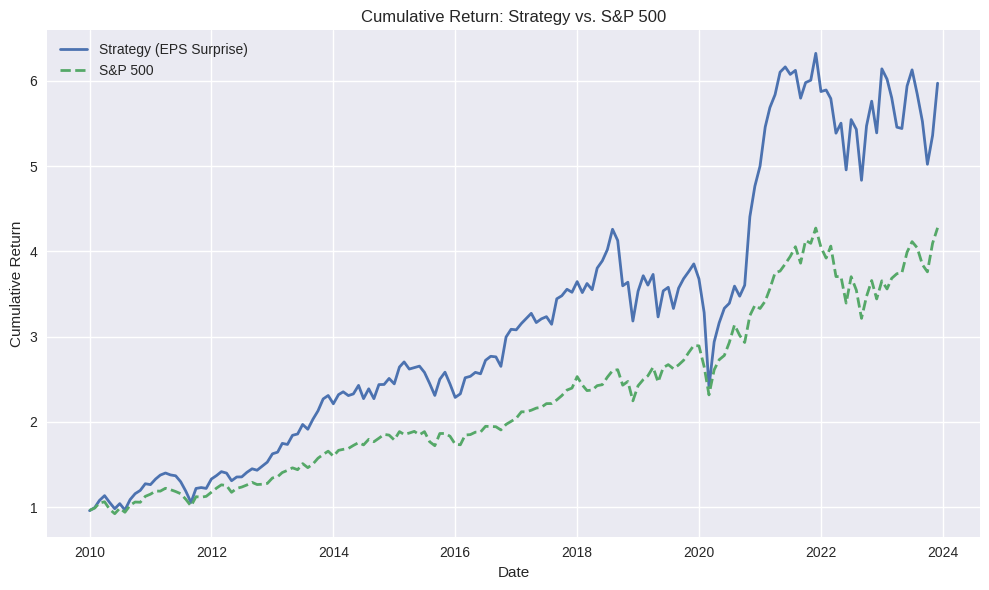

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Data ===
pred = pd.read_csv("epssurprise_regression_bayesopt.csv", parse_dates=["date"])
actual = pd.read_csv("goup_project_sample_v3.csv", parse_dates=["date"])
spy = pd.read_csv("mkt_ind1.csv")

# === Format Dates ===
actual["date"] = actual["date"].dt.to_period("M").dt.to_timestamp()
spy["date"] = pd.to_datetime(spy[["year", "month"]].assign(day=1))
spy.rename(columns={"sp_ret": "spy_ret"}, inplace=True)

# === Merge EPS Surprise Pred ===
df = pd.merge(pred, actual[["permno", "date", "stock_exret"]], on=["permno", "date"], how="left")
df = df.dropna(subset=["pred", "stock_exret"])

# === Compute OOS R² ===
y_true = df["stock_exret"].values
y_pred = df["pred"].values
oos_r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print(f"✅ OOS R²: {oos_r2:.2%}")

# === Monthly Portfolio Construction ===
long_portfolio = []

for dt, group in df.groupby("date"):
    # Select top 100 predictions (long-only)
    top = group.sort_values("pred", ascending=False).head(100)

    # Apply 10% max weight per stock, equal weight among top 50–100
    n_holdings = max(50, min(100, len(top)))
    top = top.head(n_holdings).copy()
    top["weight"] = 1 / n_holdings

    top["date"] = dt
    long_portfolio.append(top[["permno", "date", "weight", "stock_exret"]])

# === Combine all monthly portfolios
portfolio = pd.concat(long_portfolio)
portfolio["ret"] = portfolio["weight"] * portfolio["stock_exret"]

# === Aggregate monthly returns
monthly_return = portfolio.groupby("date")["ret"].sum().reset_index()

# === Merge with SPY for comparison
merged = pd.merge(monthly_return, spy[["date", "spy_ret"]], on="date", how="inner")
merged["strategy_cumret"] = (1 + merged["ret"]).cumprod()
merged["spy_cumret"] = (1 + merged["spy_ret"]).cumprod()

# === Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(merged["date"], merged["strategy_cumret"], label="Strategy (EPS Surprise)", linewidth=2)
plt.plot(merged["date"], merged["spy_cumret"], label="S&P 500", linestyle="--", linewidth=2)
plt.title("Cumulative Return: Strategy vs. S&P 500")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
monthly_return.to_csv("strategy_returns.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === Load data ===
df = pd.read_csv("mkt_ind1.csv")
portfolio = pd.read_csv("strategy_returns.csv")

# === Format dates ===
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
portfolio["date"] = pd.to_datetime(portfolio["date"])

# === Merge returns ===
merged = pd.merge(portfolio, df[["date", "sp_ret", "RF"]], on="date", how="inner")
merged["excess_ret"] = merged["ret"] - merged["RF"]
merged["spy_excess_ret"] = merged["sp_ret"] - merged["RF"]

ann_factor = 12

def compute_metrics(returns, excess_returns=None, benchmark_returns=None):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max

    ann_return = (1 + returns).prod() ** (ann_factor / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(ann_factor)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(ann_factor)
    max_dd = drawdown.min()
    max_loss = returns.min()

    alpha = beta = ir = te = np.nan
    if excess_returns is not None and benchmark_returns is not None:
        model = LinearRegression().fit(benchmark_returns.values.reshape(-1, 1), excess_returns)
        alpha = model.intercept_ * ann_factor
        beta = model.coef_[0]
        ir = (returns - benchmark_returns).mean() / (returns - benchmark_returns).std() * np.sqrt(ann_factor)
        te = np.std(returns - benchmark_returns) * np.sqrt(ann_factor)

    return {
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Alpha (Annualized)": alpha,
        "Beta": beta,
        "Information Ratio": ir,
        "Tracking Error": te,
        "Max Drawdown": max_dd,
        "Max 1-Month Loss": max_loss
    }

# === Compute strategy and S&P metrics ===
strategy_metrics = compute_metrics(
    merged["ret"],
    merged["excess_ret"],
    merged["spy_excess_ret"]
)

spy_metrics = compute_metrics(
    merged["sp_ret"],
    merged["spy_excess_ret"],
    merged["spy_excess_ret"]
)

# === Display side-by-side comparison ===
print(f"{'Metric':<25} {'Strategy':>12} {'S&P 500':>12}")
print("-" * 51)
for key in strategy_metrics:
    s = strategy_metrics[key]
    b = spy_metrics[key]
    if pd.isna(s) or pd.isna(b):
        print(f"{key:<25} {'N/A':>12} {'N/A':>12}")
    else:
        print(f"{key:<25} {s:12.2%} {b:12.2%}")


Metric                        Strategy      S&P 500
---------------------------------------------------
Annualized Return               13.60%       10.94%
Annualized Volatility           22.25%       14.82%
Sharpe Ratio                    68.76%       77.74%
Alpha (Annualized)               0.57%       -0.00%
Beta                           130.08%      100.00%
Information Ratio               38.65%      211.38%
Tracking Error                  11.94%        0.40%
Max Drawdown                   -43.42%      -24.77%
Max 1-Month Loss               -26.59%      -12.51%


In [4]:
import pandas as pd

# === Load holdings file ===
df = pd.read_csv("strategy_holdings.csv", parse_dates=["date"])

# === Sort and pivot to get weight matrix ===
df = df.sort_values(["date", "permno"])
weight_matrix = df.pivot(index="date", columns="permno", values="weight").fillna(0)

# === Calculate turnover per month ===
# Turnover = sum of absolute changes in weights month-to-month
turnover = weight_matrix.diff().abs().sum(axis=1)

# === Average Monthly Turnover
avg_turnover = turnover.mean()

# === Print monthly and average turnover
print("📌 Monthly Turnover (% of portfolio flipped):")
print(turnover.round(4))

print(f"\n✅ Average Monthly Turnover: {avg_turnover:.2%}")


📌 Monthly Turnover (% of portfolio flipped):
date
2010-01-01    0.00
2010-02-01    0.56
2010-03-01    0.38
2010-04-01    0.26
2010-05-01    0.62
              ... 
2023-08-01    0.56
2023-09-01    0.30
2023-10-01    0.26
2023-11-01    0.38
2023-12-01    0.24
Length: 168, dtype: float64

✅ Average Monthly Turnover: 36.04%
